In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: 0.23989245728501618, node: COCC1C(C)(C)CN1C(=O)NC[C@H]1CCc2ccccc2O1
1- time: 0.08, count_rollouts: 3, reward: 0.15065247843950605, node: N#Cc1ccccc1-c1nnn(CC(=O)N2CCN(c3ccccc3)C2)n1
2- time: 0.13, count_rollouts: 4, reward: 0.34148270834695205, node: c1cc(SCNCc2ccsc2)nc(CCc2ccccn2)n1
3- time: 0.18, count_rollouts: 5, reward: 0.28594080116818477, node: FCS(=O)(=O)C1CCN(C(=O)c2cc(-c3cccc(Cl)c3)no2)CC1
4- time: 0.27, count_rollouts: 7, reward: 0.2274512355695093, node: Clc1ccccc1NC(=O)[C@H]1CCOC1
5- time: 0.53, count_rollouts: 13, reward: 0.42020256529168687, node: c1ccc([C@H]2CCCC[C@H]2C(=O)Nc3ccc(OC)c(C#N)c3)cc1
6- time: 0.68, count_rollouts: 16, reward: 0.4437896150450112, node: Clc1ccc2nc(OC)c(OC(=O)c3ccccc3Cl)cc2c1
7- time: 0.82, count_rollouts: 19, reward: 0.32736133125602906, node: ClC(=O)Nc1ccc(S(=O)(=O)NCCCC(=O)c2ccccc2)cc1
8- time: 0.91, count_rollouts: 21, reward: 0.21817586393366012, node: O=C(CCn1ccc(-c2ccccc2)n1)N[

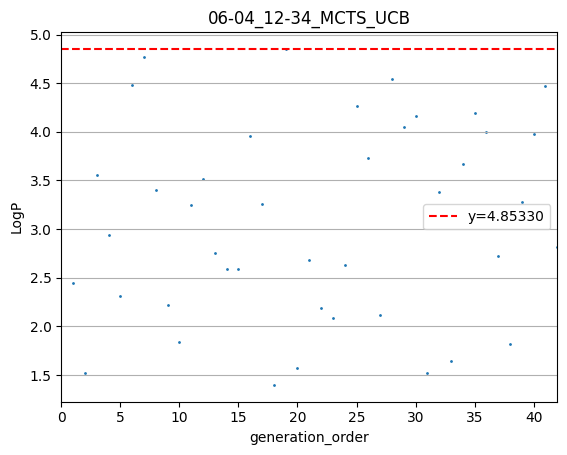

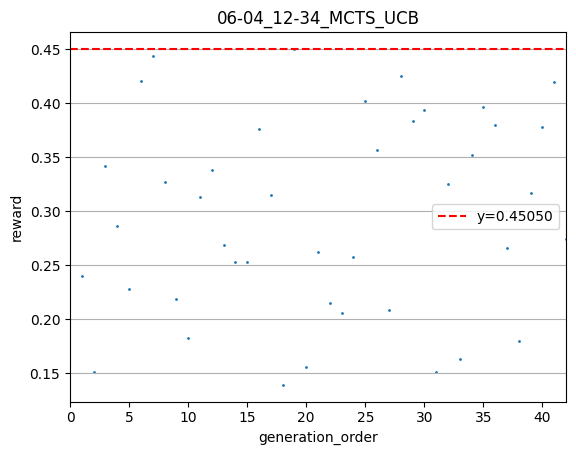

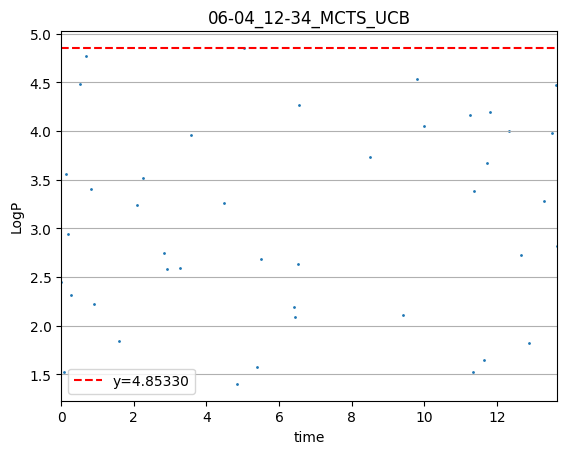

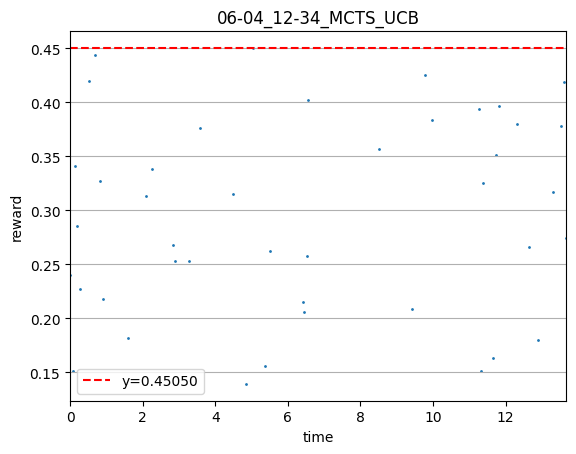

Search is completed.


In [21]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)